In [31]:
import os
print(f"현재 PID: {os.getpid()}")

현재 PID: 3085216


Using device: cuda:1
[DEBUG] act shape: torch.Size([512, 12, 12]), grad shape: torch.Size([512, 12, 12])
[DEBUG] CAM max: 0.4799, min: -0.5726
[DEBUG] CAM shape: (12, 12)
[DEBUG] Original mask shape: (360, 360), sum: 49.0
[DEBUG] Resized mask → CAM shape: (12, 12), sum: 0.0
[DEBUG] Resized CAM shape: (360, 360), max: 0.99

[CAM 기준] CAM@BBox = 0.0000
[Mask 기준] CAM@BBox = 1.0256


/opt/anaconda3/envs/lungcancer/lib/python3.12/site-packages/torch/nn/modules/module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


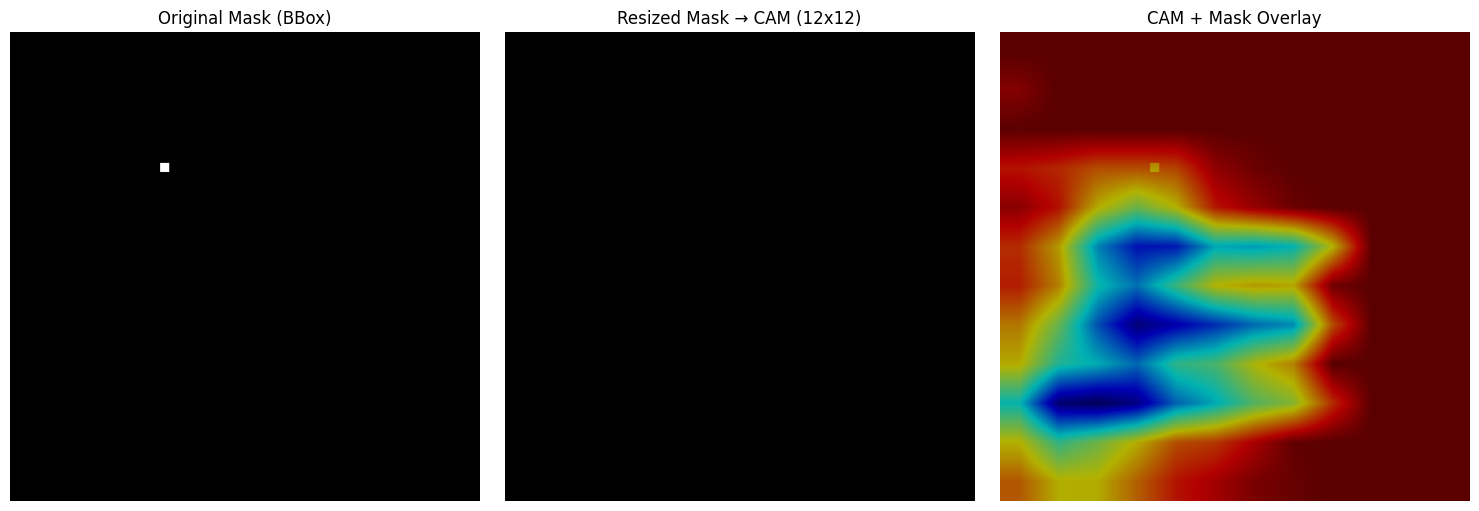

In [7]:
import os
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import ast
from skimage.transform import resize

import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..")))

from ResNet18_CBAM_MGA.core.model import ResNet18_CBAM
from ResNet18_CBAM_MGA.core.config import CFG
from ResNet18_CBAM_MGA.visualize.grad_cam import generate_cam

# ✅ 기본 설정
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ 테스트 대상 설정
npy_path = "/data1/lidc-idri/slices/LIDC-IDRI-0434/slice_050_4.npy"
bbox_csv_path = "/home/iujeong/lung_cancer/csv/bbox_for_npy.csv"

# ✅ 모델 로딩
model_path = "/home/iujeong/lung_cancer/logs/r18_cbam_norotate_sc_no_mask_no_rotate_0522_2045.pth"
model = ResNet18_CBAM(num_classes=CFG.num_classes).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# ✅ bbox CSV 로딩 및 dict 구성
df = pd.read_csv(bbox_csv_path)
df['bbox'] = df['bbox'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
bbox_dict = df.groupby('file')['bbox'].apply(list).to_dict()

# ✅ 파일 이름 키 매칭
pid = os.path.basename(os.path.dirname(npy_path))       # LIDC-IDRI-0434
fname = os.path.basename(npy_path)                      # slice_050_4.npy
slice_key = f"{pid}/{fname}"                            # LIDC-IDRI-0434/slice_050_4.npy

# ✅ 이미지 로딩 및 전처리
img = np.load(npy_path)
img = np.clip(img, -1000, 400)
img = (img + 1000) / 1400.0
img = img.astype(np.float32)
img_tensor = torch.tensor(img).unsqueeze(0).unsqueeze(0).to(device)  # (1, 1, H, W)

# ✅ Grad-CAM 생성
cam = generate_cam(model, img_tensor).squeeze().cpu().numpy()  # (H, W)
cam_h, cam_w = cam.shape
print(f"[DEBUG] CAM shape: {cam.shape}")

# ✅ 마스크 생성
def create_mask(bboxes, image_size=(512, 512)):
    mask = np.zeros(image_size, dtype=np.float32)
    for box in bboxes:
        (y1, y2), (x1, x2) = box
        mask[y1:y2, x1:x2] = 1.0
    return mask

mask = create_mask(bbox_dict[slice_key], image_size=img.shape)
print(f"[DEBUG] Original mask shape: {mask.shape}, sum: {mask.sum()}")

# ✅ 마스크 → CAM 해상도로 리사이즈 (방법 1)
resized_mask = resize(mask, (cam_h, cam_w), order=0, preserve_range=True, anti_aliasing=False)
print(f"[DEBUG] Resized mask → CAM shape: {resized_mask.shape}, sum: {resized_mask.sum()}")

# ✅ CAM → 마스크 해상도로 리사이즈 (방법 2)
resized_cam = cv2.resize(cam, dsize=(mask.shape[1], mask.shape[0]), interpolation=cv2.INTER_LINEAR)
normed_cam = (resized_cam - resized_cam.min()) / (resized_cam.max() - resized_cam.min() + 1e-8)

print(f"[DEBUG] Resized CAM shape: {resized_cam.shape}, max: {resized_cam.max():.2f}")

# ✅ CAM@BBox 계산
cam_all_mean_1 = cam.mean()
cam_bbox_mean_1 = cam[resized_mask > 0].mean() if resized_mask.sum() > 0 else 0
cam_ratio_1 = cam_bbox_mean_1 / (cam_all_mean_1 + 1e-8)

cam_all_mean_2 = resized_cam.mean()
cam_bbox_mean_2 = resized_cam[mask > 0].mean() if mask.sum() > 0 else 0
cam_ratio_2 = cam_bbox_mean_2 / (cam_all_mean_2 + 1e-8)

print(f"\n[CAM 기준] CAM@BBox = {cam_ratio_1:.4f}")
print(f"[Mask 기준] CAM@BBox = {cam_ratio_2:.4f}")

# ✅ 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. 원본 마스크
axes[0].imshow(mask, cmap='gray')
axes[0].set_title("Original Mask (BBox)")

# 2. 마스크 → CAM 해상도
axes[1].imshow(resized_mask, cmap='gray')
axes[1].set_title(f"Resized Mask → CAM ({cam_h}x{cam_w})")

# 3. CAM + Mask Overlay
overlay = cv2.applyColorMap(np.uint8(255 * normed_cam), cv2.COLORMAP_JET)
mask_rgb = np.zeros_like(overlay)
mask_rgb[:, :, 1] = (mask > 0) * 255
overlay_masked = cv2.addWeighted(overlay, 0.7, mask_rgb, 0.3, 0)
axes[2].imshow(overlay_masked)
axes[2].set_title("CAM + Mask Overlay")

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

Using device: cuda:1


/tmp/ipykernel_2677213/1350996583.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_df['file_name'] = correct_df['file'].apply(lambda x: os.path.basename(x))
/opt/anaconda3/envs/lungcancer/lib/python3.12/site-packages/torch/nn/modules/module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


[DEBUG] act shape: torch.Size([512, 9, 9]), grad shape: torch.Size([512, 9, 9])
[DEBUG] CAM max: 3713.2212, min: 382.4338
[DEBUG] act shape: torch.Size([512, 13, 13]), grad shape: torch.Size([512, 13, 13])
[DEBUG] CAM max: 2179.9097, min: 75.3227
[DEBUG] act shape: torch.Size([512, 10, 10]), grad shape: torch.Size([512, 10, 10])
[DEBUG] CAM max: 3228.6421, min: 257.3745
[DEBUG] act shape: torch.Size([512, 10, 10]), grad shape: torch.Size([512, 10, 10])
[DEBUG] CAM max: 1324.4806, min: -7.7899
[DEBUG] act shape: torch.Size([512, 11, 11]), grad shape: torch.Size([512, 11, 11])
[DEBUG] CAM max: 2915.1289, min: -137.2750
[DEBUG] act shape: torch.Size([512, 12, 12]), grad shape: torch.Size([512, 12, 12])
[DEBUG] CAM max: 1160.7651, min: -8.8894
[DEBUG] act shape: torch.Size([512, 14, 14]), grad shape: torch.Size([512, 14, 14])
[DEBUG] CAM max: 1819.3199, min: -429.2399
[DEBUG] act shape: torch.Size([512, 10, 10]), grad shape: torch.Size([512, 10, 10])
[DEBUG] CAM max: 3322.6978, min: -5.934

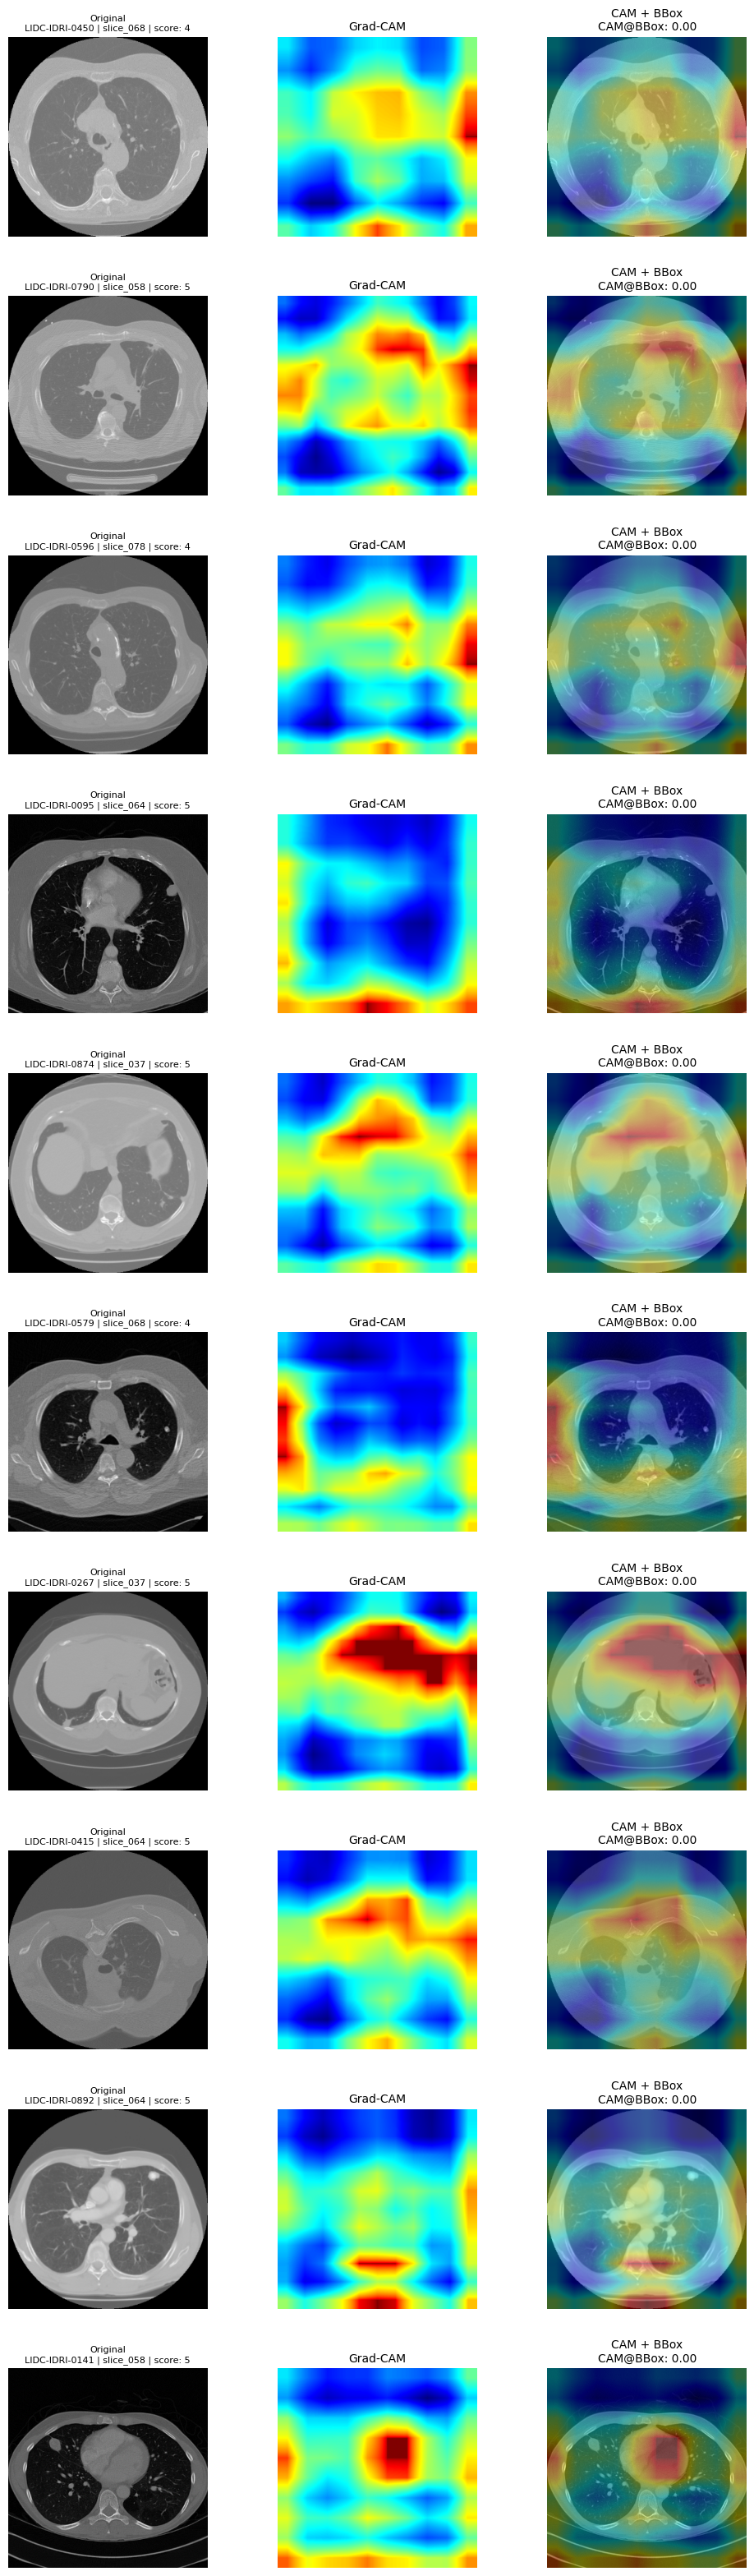

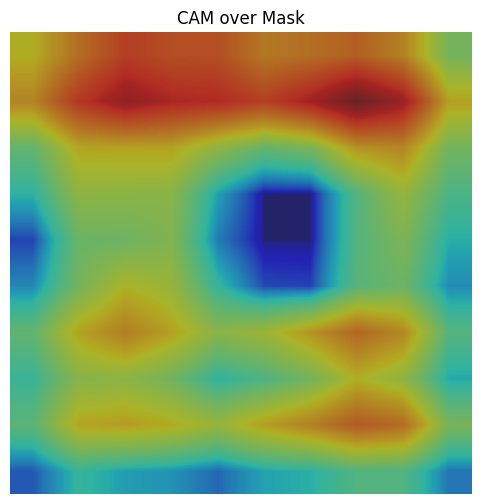

📸 CAM 리포트 저장 완료: gradcam_outputs_mask/summary_report_bbox_True_top_CAM10.png
📄 CAM@BBox 수치 저장 완료: gradcam_outputs_mask/cam_bbox_metrics_best_True_top_CAM10.csv


<Figure size 640x480 with 0 Axes>

In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import ast
from skimage.transform import resize

import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..")))

# 내부 모듈
from ResNet18_CBAM_MGA.core.model import ResNet18_CBAM
from ResNet18_CBAM_MGA.core.config import CFG
from ResNet18_CBAM_MGA.visualize.grad_cam import generate_cam

# ✅ 디바이스 설정
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ 경로 설정
data_root = "/data1/lidc-idri/slices"
bbox_csv_path = "/home/iujeong/lung_cancer/csv/bbox_for_npy.csv"
sample_csv_path = "/home/iujeong/lung_cancer/logs/samplewise_metrics.csv"
save_dir = "gradcam_outputs_mask"
os.makedirs(save_dir, exist_ok=True)

# ✅ BBox 로딩
bbox_df = pd.read_csv(bbox_csv_path)
bbox_df['bbox'] = bbox_df['bbox'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
bbox_grouped = bbox_df.groupby('file')['bbox'].apply(list).to_dict()

# ✅ 평가 파일 로딩
df = pd.read_csv(sample_csv_path)

def npy_to_bbox_key(path):
    pid = os.path.basename(os.path.dirname(path))
    fname = os.path.basename(path)  # slice_037_5.npy
    return f"{pid}/{fname}"

df['bbox_key'] = df['file'].apply(npy_to_bbox_key)

# ✅ CAM 결과 불러와서 CAM@BBox >= 0.8인 정답만 필터링
cam_result_df = pd.read_csv("gradcam_outputs_mask/cam_bbox_metrics_best_True.csv")
good_cam_files = set(cam_result_df[cam_result_df['CAM@BBox'] >= 0.8]['file'])

correct_df = df[df['pred'] == df['label']]
correct_df['file_name'] = correct_df['file'].apply(lambda x: os.path.basename(x))
selected = correct_df[correct_df['file_name'].isin(good_cam_files)]
selected = selected.sort_values(by="loss", ascending=True).head(10)

# ✅ 모델 로딩
CFG.model_save_name = "r18_cbam_norotate_sc_no_mask_no_rotate_0522_2045.pth"
model_path = os.path.join("/home/iujeong/lung_cancer/logs", CFG.model_save_name)
model = ResNet18_CBAM(num_classes=CFG.num_classes).to(device).eval()
model.load_state_dict(torch.load(model_path, map_location=device))

# ✅ 결과 저장 리스트 초기화
results = []

# ✅ 시각화 준비
fig, axs = plt.subplots(10, 3, figsize=(12, 40))
fig.subplots_adjust(hspace=0.3)

for row_idx, row in enumerate(selected.itertuples()):
    npy_path = row.file
    bbox_key = row.bbox_key

    # PID, 슬라이스, 스코어 추출
    fname = os.path.basename(npy_path).replace(".npy", "")
    parts = fname.split("_")
    slice_id, score = parts[1], parts[2]
    pid = os.path.basename(os.path.dirname(npy_path))

    # 이미지 로드
    img = np.load(npy_path)
    if img.ndim == 2:
        img = np.expand_dims(img, axis=0)
    img_tensor = torch.tensor(img).unsqueeze(0).float().to(device)

    # Grad-CAM 생성
    cam = generate_cam(model, img_tensor).squeeze().cpu().numpy()
    cam = cv2.resize(cam, (img.shape[2], img.shape[1]))
    cam = np.sqrt(cam)
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    cam_heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

    # 원본 이미지
    ori_img = img[0]
    ori_norm = (ori_img - ori_img.min()) / (ori_img.max() - ori_img.min() + 1e-8)
    ori_bgr = cv2.cvtColor(np.uint8(255 * ori_norm), cv2.COLOR_GRAY2BGR)

    # CAM overlay
    overlay = cv2.addWeighted(ori_bgr, 0.6, cam_heatmap, 0.4, 0)

    # 💡 스케일 조정 함수 정의 (한 번만 정의해두면 돼)
    def rescale_bbox(box, original_shape, target_shape):
        """
        box: [[y1, y2], [x1, x2]]
        original_shape: 원본 이미지 크기 (H, W) → 보통 (512, 512)
        target_shape: 현재 이미지 크기 (H, W) → 예: (224, 224) or CAM.shape
        """
        (y1, y2), (x1, x2) = box
        h_in, w_in = original_shape
        h_out, w_out = target_shape

        y1 = int(y1 / h_in * h_out)
        y2 = int(y2 / h_in * h_out)
        x1 = int(x1 / w_in * w_out)
        x2 = int(x2 / w_in * w_out)

        return (y1, y2), (x1, x2)

    # ✅ BBox + mask 처리
    mask = np.zeros((img.shape[1], img.shape[2]), dtype=np.uint8)
    input_shape = (512, 512)  # 너의 BBox 기준
    target_shape = (img.shape[1], img.shape[2])  # 현재 이미지 (예: 224x224)

    def overlay_bbox_on_image(image, bboxes, original_shape=(512, 512), color=(0, 255, 0)):
        """
        image: CAM이나 원본 이미지 (H, W, 3) - 시각화 대상
        bboxes: 원본 기준 좌표 목록 (ex. [[y1, y2], [x1, x2]])
        original_shape: bbox가 기준한 원본 크기 (보통 512×512)
        """
        h_img, w_img = image.shape[:2]
        mask = np.zeros((img.shape[1], img.shape[2]), dtype=np.uint8)
        for raw_box in bbox_grouped.get(bbox_key, []):
            try:
                box = ast.literal_eval(raw_box) if isinstance(raw_box, str) else raw_box
                if isinstance(box[0][0], list):
                    box = box[0]
                (y1, y2), (x1, x2) = rescale_bbox(box, input_shape, target_shape)
                if y1 == y2:
                    y2 += 1
                if x1 == x2:
                    x2 += 1
                mask[y1:y2, x1:x2] = 1
            except Exception as e:
                print(f"[BBox mask ERROR] {raw_box} → {e}")

    mask_rgb = np.zeros_like(ori_bgr)
    mask_rgb[:, :, 2] = mask * 255
    overlay = cv2.addWeighted(overlay, 1.0, mask_rgb, 0.4, 0)

    # CAM@BBox 계산
    # Step 1: 마스크를 CAM 해상도로 리사이즈
    cam_h, cam_w = cam.shape
    
    # mask가 torch.Tensor일 수도 있고, numpy일 수도 있을 경우
    if isinstance(mask, torch.Tensor):
        mask_np = mask.cpu().numpy()
    else:
        mask_np = mask  # 이미 numpy면 그대로 사용

    # CAM 해상도로 resize
    # CAM → 마스크 해상도로 리사이즈
    resized_cam = cv2.resize(cam, dsize=(mask.shape[1], mask.shape[0]), interpolation=cv2.INTER_LINEAR)

    # CAM@BBox 계산
    cam_all_mean = resized_cam.mean()
    cam_bbox_mean = resized_cam[mask > 0].mean() if mask.sum() > 0 else 0
    cam_ratio = cam_bbox_mean / (cam_all_mean + 1e-8)

    # 결과 저장
    results.append({
        "file": os.path.basename(npy_path),
        "pid": pid,
        "slice": slice_id,
        "score": score,
        "cam_mean": float(cam_all_mean),
        "cam_bbox_mean": float(cam_bbox_mean),
        "CAM@BBox": float(cam_ratio)
    })

    # 시각화
    axs[row_idx, 0].imshow(ori_bgr)
    axs[row_idx, 0].set_title(f"Original\n{pid} | slice_{slice_id} | score: {score}", fontsize=8)
    axs[row_idx, 1].imshow(cam_heatmap)
    axs[row_idx, 1].set_title("Grad-CAM", fontsize=10)
    axs[row_idx, 2].imshow(overlay)
    axs[row_idx, 2].set_title(f"CAM + BBox\nCAM@BBox: {cam_ratio:.2f}", fontsize=10)
    for col in range(3):
        axs[row_idx, col].axis("off")

    torch.cuda.empty_cache()

# CAM과 mask 시각화 겹쳐보기
plt.figure(figsize=(6, 6))
plt.imshow(resized_cam, cmap='jet', alpha=0.8)
plt.imshow(mask, cmap='gray', alpha=0.3)
plt.title("CAM over Mask")
plt.axis('off')
plt.show()

# 이미지 저장
out_path = os.path.join(save_dir, "summary_report_bbox_True_top_CAM10.png")
plt.tight_layout()
plt.savefig(out_path)
print(f"📸 CAM 리포트 저장 완료: {out_path}")

# CSV 저장
csv_path = os.path.join(save_dir, "cam_bbox_metrics_best_True_top_CAM10.csv")
pd.DataFrame(results).to_csv(csv_path, index=False)
print(f"📄 CAM@BBox 수치 저장 완료: {csv_path}")

In [15]:
print(f"[DEBUG] cam_bbox_mean: {cam_bbox_mean}")
print(f"[DEBUG] cam_all_mean : {cam_all_mean}")
print(f"[DEBUG] CAM@BBox      : {cam_ratio}")

[DEBUG] cam_bbox_mean: 0
[DEBUG] cam_all_mean : 0.5624492168426514
[DEBUG] CAM@BBox      : 0.0


In [12]:
# bbox 처리 후 디버깅
print(f"[DEBUG] Before mask sum: {mask.sum()}")
for raw_box in bbox_grouped.get(bbox_key, []):
    try:
        box = ast.literal_eval(raw_box) if isinstance(raw_box, str) else raw_box
        if isinstance(box[0][0], list):
            box = box[0]
        (y1, y2), (x1, x2) = rescale_bbox(box, input_shape, target_shape)
        print(f"[DEBUG] Drawing BBox: y1={y1}, y2={y2}, x1={x1}, x2={x2}")
        mask[y1:y2, x1:x2] = 1
    except Exception as e:
        print(f"[BBox mask ERROR] {raw_box} → {e}")

print(f"[DEBUG] After mask sum: {mask.sum()}")

[DEBUG] Before mask sum: 0
[DEBUG] Drawing BBox: y1=40, y2=52, x1=68, x2=83
[DEBUG] After mask sum: 180


Using device: cuda:1
💬 [INFO] CT file: /data1/lidc-idri/slices/LIDC-IDRI-0346/slice_075_1.npy
💬 [INFO] File name: slice_075_1.npy
💬 [INFO] Label: 0
💬 [INFO] BBox key used: LIDC-IDRI-0346_slice_75.npy


/opt/anaconda3/envs/lungcancer/lib/python3.12/site-packages/torch/nn/modules/module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


💥 pred vs label: 0 0


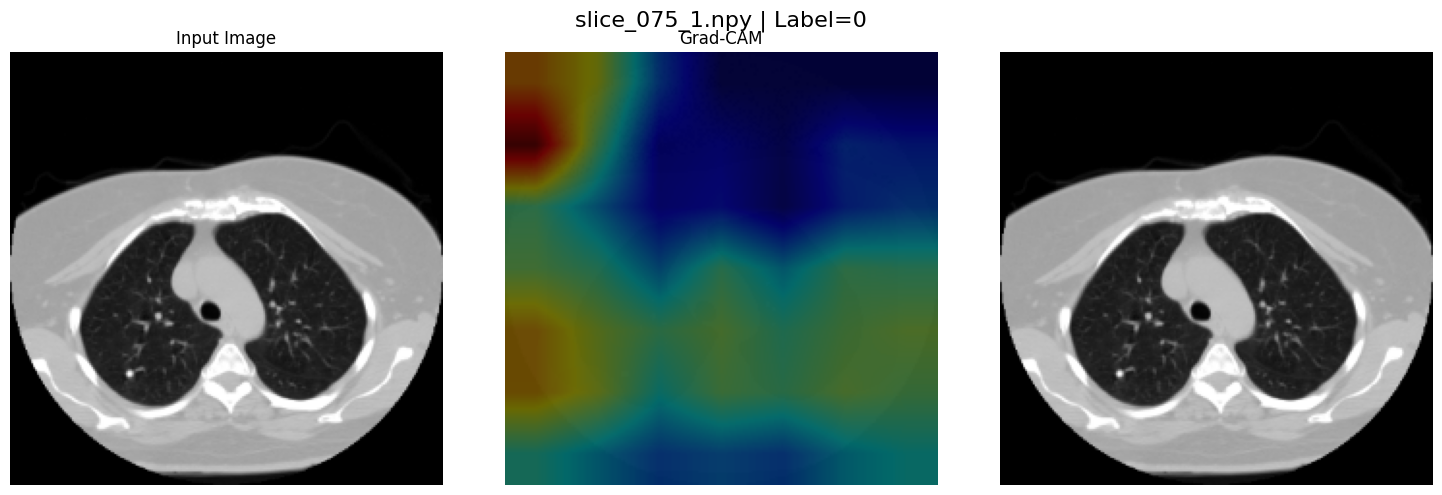

In [13]:
# ✅ Grad-CAM + Bounding Box Overlay (실제 CT 기반 최종 정리)

import os
import re
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torch.nn.functional as F
import cv2
import pandas as pd
import sys
sys.path.append("/home/iujeong/lung_cancer")
from glob import glob
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from ResNet18_CBAM_MGA.core.config import CFG
from ResNet18_CBAM_MGA.core.dataset import CTDataset, load_bbox_dict, extract_label
from ResNet18_CBAM_MGA.core.model import ResNet18_CBAM
from ResNet18_CBAM_MGA.core.transforms import val_transform

# ✅ 디바이스 설정
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------- 설정 --------------------
slice_root = "/data1/lidc-idri/slices"
bbox_csv_path = "/home/iujeong/lung_cancer/csv/allbb_noPoly.csv"
save_path = "/home/iujeong/lung_cancer/logs/r18_cbam_mga_norotate_sc_mask_norotate_0520_2219.pth"
image_size = (224, 224)


# -------------------- 라벨 추출 --------------------
def extract_label_from_filename(fname):
    try:
        score = int(fname.split("_")[-1].replace(".npy", ""))
        return None if score == 3 else int(score >= 4)
    except:
        return None

# -------------------- Bounding Box 로드 --------------------
def load_bbox_dict(csv_path):
    df = pd.read_csv(csv_path)
    bbox_dict = {}
    for _, row in df.iterrows():
        pid = row['pid']                      # e.g. "LIDC-IDRI-0191"
        slice_str = row['slice']              # e.g. "slice_76"
        fname = f"{pid}_{slice_str}.npy"      # e.g. "LIDC-IDRI-0191_slice_76.npy"
        bbox = eval(row['bb'])                # 💡 bbox는 튜플
        bbox_dict.setdefault(fname, []).append(bbox)
    return bbox_dict

# -------------------- Grad-CAM --------------------
def generate_gradcam(model, image, target_layer, class_idx=None):
    activations, gradients = [], []
    def forward_hook(module, input, output): activations.append(output)
    def backward_hook(module, grad_input, grad_output): gradients.append(grad_output[0])
    hook_fwd = target_layer.register_forward_hook(forward_hook)
    hook_bwd = target_layer.register_backward_hook(backward_hook)
    if image.ndim == 3: image = image.unsqueeze(0)
    model.zero_grad()
    
    output = model(image.to(device))
    pred = output.argmax().item()
    print("💥 pred vs label:", pred, label.item())

    if class_idx is None: class_idx = output.argmax().item()
    output[0, class_idx].backward()
    act = activations[0].detach(); grad = gradients[0].detach()
    weights = grad.mean(dim=(2, 3), keepdim=True)
    cam = F.relu((weights * act).sum(dim=1)).squeeze()
    cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=image_size, mode='bilinear', align_corners=False).squeeze()
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    hook_fwd.remove(); hook_bwd.remove()
    return cam.cpu().numpy()

# -------------------- 데이터 로딩 --------------------
bbox_dict = load_bbox_dict(bbox_csv_path)
all_files = glob(os.path.join(slice_root, "LIDC-IDRI-*", "*.npy"))
file_label_pairs = [(f, extract_label_from_filename(f)) for f in all_files]
file_label_pairs = [(f, l) for f, l in file_label_pairs if l is not None]
files, labels = zip(*file_label_pairs)
_, temp_files, _, temp_labels = train_test_split(files, labels, test_size=0.3, random_state=42)
_, test_files, _, test_labels = train_test_split(temp_files, temp_labels, test_size=0.5, random_state=42)

# -------------------- 모델 로드 --------------------

dataset = CTDataset(test_files, test_labels, bbox_dict, transform=val_transform)
test_loader = DataLoader(dataset, batch_size=1)

model = ResNet18_CBAM().to(device)
model.load_state_dict(torch.load(save_path))  # 오류 안 나야 함!
model.eval()

# -------------------- 시각화 --------------------
idx = random.randint(0, len(dataset) - 1)
img_tensor, label, mask, fname, file_path = dataset[idx]
if isinstance(file_path, tuple): file_path = file_path[0]
if isinstance(fname, tuple): fname = fname[0]

print(f"💬 [INFO] CT file: {file_path}")
print(f"💬 [INFO] File name: {fname}")
print(f"💬 [INFO] Label: {label.item()}")

patient_id = os.path.basename(os.path.dirname(file_path))  # e.g. LIDC-IDRI-0191
slice_index = int(fname.split("_")[1])                     # e.g. 78

bbox_key = f"{patient_id}_slice_{slice_index}.npy"         # 👈 zero padding 제거된 key!
print(f"💬 [INFO] BBox key used: {bbox_key}")
# cam = generate_gradcam(model, img_tensor, model.layer3[1], class_idx=label.item())
# cam = generate_gradcam(model, img_tensor, model.layer4[1], class_idx=label.item())
# cam = generate_gradcam(model, img_tensor, model.layer3[0], class_idx=label.item())
cam = generate_gradcam(model, img_tensor, model.layer4[-1], class_idx=label.item())
img_np = img_tensor.squeeze().cpu().numpy()
img_uint8 = (img_np * 255).astype(np.uint8)

orig_h, orig_w = np.load(file_path).shape

heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

# 원본 이미지 밝기 조정해서 깔기
# 💡 CLAHE 적용 + 밝기/대비 조절 조합
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
img_clahe = clahe.apply(img_uint8)  # 히스토그램 균등화
input_rgb = cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2RGB)
overlay_for_gradcam = cv2.addWeighted(input_rgb, 0.6, heatmap, 0.4, 0)
overlay_for_bbox = cv2.convertScaleAbs(input_rgb, alpha=2.0, beta=80)

# BBox 덧씌우기
for raw_bbox in bbox_dict.get(bbox_key, []):
    if len(raw_bbox) == 1 and isinstance(raw_bbox[0], list):
        raw_bbox = raw_bbox[0]
    try:
        (x1, x2), (y1, y2) = raw_bbox
    except Exception as e:
        print(f"[WARNING] bbox malformed: {raw_bbox} → {e}")
        continue
    x1 = int(x1 * image_size[1] / orig_w)
    x2 = int(x2 * image_size[1] / orig_w)
    y1 = int(y1 * image_size[0] / orig_h)
    y2 = int(y2 * image_size[0] / orig_h)
    cv2.rectangle(overlay_for_bbox, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)

# -------------------- 시각화 --------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f"{fname} | Label={label.item()}", fontsize=16)

# 1. 원본
axes[0].imshow(img_np, cmap='gray')
axes[0].set_title("Input Image")
axes[0].axis('off')

# 2. Grad-CAM
axes[1].imshow(overlay_for_gradcam)
axes[1].set_title("Grad-CAM")
axes[1].axis('off')

# ✅ 3. CT 원본 + BBox 겹치기 (정답)
axes[2].imshow(img_np, cmap='gray', alpha=1.0)  # 배경을 CT 원본으로 깔고
axes[2].imshow(np.zeros_like(img_np), cmap='gray', alpha=0.0)  # matplotlib 렌더링 에러 방지용

# bbox_color = (0, 255, 0) if label.item() == 1 else (255, 0, 0)

# BBox 덧씌우기
import matplotlib.patches as patches

for raw_bbox in bbox_dict.get(bbox_key, []):
    if len(raw_bbox) == 1 and isinstance(raw_bbox[0], list):
        raw_bbox = raw_bbox[0]
    try:
        (x1, x2), (y1, y2) = raw_bbox
    except Exception as e:
        continue
    x1 = int(x1 * image_size[1] / orig_w)
    x2 = int(x2 * image_size[1] / orig_w)
    y1 = int(y1 * image_size[0] / orig_h)
    y2 = int(y2 * image_size[0] / orig_h)
    
    color = 'lime' if label.item() == 1 else 'red'
    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                             linewidth=2, edgecolor=color, facecolor='none')
    axes[2].add_patch(rect)

axes[2].imshow(img_np, cmap='gray')  # CT 원본 선명하게
# OpenCV로 box 그린 이미지 → 이걸 그대로 시각화
# axes[2].imshow(overlay_for_bbox)
# axes[2].set_title(f"Overlay with BBox (Label={label.item()})")
axes[2].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import ast

# 내부 모듈
from ResNet18_CBAM_MGA.core.model import ResNet18_CBAM
from ResNet18_CBAM_MGA.core.config import CFG
from ResNet18_CBAM_MGA.visualize.grad_cam import generate_cam

# ✅ 디바이스 설정
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ 경로 설정
data_root = "/data1/lidc-idri/slices"
bbox_csv_path = "/home/iujeong/lung_cancer/csv/bbox_for_npy.csv"
sample_csv_path = "/home/iujeong/lung_cancer/logs/samplewise_metrics.csv"
save_dir = "gradcam_outputs_mask"
os.makedirs(save_dir, exist_ok=True)

# ✅ BBox 로딩
bbox_df = pd.read_csv(bbox_csv_path)
bbox_df['bbox'] = bbox_df['bbox'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
bbox_grouped = bbox_df.groupby('file')['bbox'].apply(list).to_dict()

# ✅ 평가 파일 로딩
df = pd.read_csv(sample_csv_path)

def npy_to_bbox_key(path):
    pid = os.path.basename(os.path.dirname(path))
    fname = os.path.basename(path)  # slice_037_5.npy
    return f"{pid}/{fname}"

df['bbox_key'] = df['file'].apply(npy_to_bbox_key)

# # ✅ CAM 결과 불러와서 CAM@BBox >= 0.8인 정답만 필터링
# cam_result_df = pd.read_csv("gradcam_outputs_mask/cam_bbox_metrics_best_True.csv")
# good_cam_files = set(cam_result_df[cam_result_df['CAM@BBox'] >= 0.8]['file'])

# correct_df = df[df['pred'] == df['label']]
# correct_df['file_name'] = correct_df['file'].apply(lambda x: os.path.basename(x))
# # selected = correct_df[correct_df['file_name'].isin(good_cam_files)]
# # selected = selected.sort_values(by="loss", ascending=True).head(10)
# # 기존 자동 리포트 코드에 다음 추가


# ✅ CAM@BBox ≥ 0.8인 정답 샘플만 필터링
cam_result_df = pd.read_csv("gradcam_outputs_mask/cam_bbox_metrics_best_True.csv")
# 1. CAM 결과에 파일 이름 붙이기
cam_result_df['file_name'] = cam_result_df['file'].apply(lambda x: os.path.basename(x))

# 2. CAM 결과에서 기준 넘는 것만 필터링
good_cam_df = cam_result_df[cam_result_df['CAM@BBox'] >= 0.8]

# 3. 평가 결과에서 정답 맞춘 애들 중 CAM 높은 애들과 병합
correct_df = df[df['pred'] == df['label']]
correct_df['file_name'] = correct_df['file'].apply(lambda x: os.path.basename(x))

selected = pd.merge(correct_df, good_cam_df, on='file_name')
selected = selected.sample(n=10, random_state=42)  # 다양성 확보!


# ✅ 모델 로딩
CFG.model_save_name = "r18_cbam_norotate_sc_no_mask_no_rotate_0522_2045.pth"
model_path = os.path.join("/home/iujeong/lung_cancer/logs", CFG.model_save_name)
model = ResNet18_CBAM(num_classes=CFG.num_classes).to(device).eval()
model.load_state_dict(torch.load(model_path, map_location=device))

# ✅ 결과 저장 리스트 초기화
results = []

# ✅ 시각화 준비
fig, axs = plt.subplots(10, 3, figsize=(12, 40))
fig.subplots_adjust(hspace=0.3)

for row_idx, row in enumerate(selected.itertuples()):
    npy_path = row.file
    bbox_key = row.bbox_key

    # PID, 슬라이스, 스코어 추출
    fname = os.path.basename(npy_path).replace(".npy", "")
    parts = fname.split("_")
    slice_id, score = parts[1], parts[2]
    pid = os.path.basename(os.path.dirname(npy_path))

    # 이미지 로드
    img = np.load(npy_path)
    if img.ndim == 2:
        img = np.expand_dims(img, axis=0)
    img_tensor = torch.tensor(img).unsqueeze(0).float().to(device)

    # Grad-CAM 생성
    cam = generate_cam(model, img_tensor).squeeze().cpu().numpy()
    cam = cv2.resize(cam, (img.shape[2], img.shape[1]))
    cam = np.sqrt(cam)
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    cam_heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

    # 원본 이미지
    ori_img = img[0]
    ori_norm = (ori_img - ori_img.min()) / (ori_img.max() - ori_img.min() + 1e-8)
    ori_bgr = cv2.cvtColor(np.uint8(255 * ori_norm), cv2.COLOR_GRAY2BGR)

    # CAM overlay
    overlay = cv2.addWeighted(ori_bgr, 0.6, cam_heatmap, 0.4, 0)

    # BBox + mask
    mask = np.zeros((img.shape[1], img.shape[2]), dtype=np.uint8)
    for raw_box in bbox_grouped[bbox_key]:
        try:
            box = ast.literal_eval(raw_box) if isinstance(raw_box, str) else raw_box
            if isinstance(box[0][0], list):
                box = box[0]
            (y1, y2), (x1, x2) = box
            cv2.rectangle(overlay, (x1, y1), (x2, y2), (0, 255, 0), 2)
            mask[y1:y2 + 1, x1:x2 + 1] = 1
        except Exception as e:
            print(f"[WARNING] bbox malformed: {raw_box} → {e}")
            continue

    mask_rgb = np.zeros_like(ori_bgr)
    mask_rgb[:, :, 2] = mask * 255
    overlay = cv2.addWeighted(overlay, 1.0, mask_rgb, 0.4, 0)

    # CAM@BBox 계산
    cam_all_mean = cam.mean()
    cam_bbox_mean = cam[mask == 1].mean() if mask.sum() > 0 else 0
    cam_ratio = cam_bbox_mean / (cam_all_mean + 1e-8)

    # 결과 저장
    results.append({
        "file": os.path.basename(npy_path),
        "pid": pid,
        "slice": slice_id,
        "score": score,
        "cam_mean": float(cam_all_mean),
        "cam_bbox_mean": float(cam_bbox_mean),
        "CAM@BBox": float(cam_ratio)
    })

    # 시각화
    axs[row_idx, 0].imshow(ori_bgr)
    axs[row_idx, 0].set_title(f"Original\n{pid} | slice_{slice_id} | score: {score}", fontsize=8)
    axs[row_idx, 1].imshow(cam_heatmap)
    axs[row_idx, 1].set_title("Grad-CAM", fontsize=10)
    axs[row_idx, 2].imshow(overlay)
    axs[row_idx, 2].set_title(f"CAM + BBox\nCAM@BBox: {cam_ratio:.2f}", fontsize=10)
    for col in range(3):
        axs[row_idx, col].axis("off")

    torch.cuda.empty_cache()

# 이미지 저장
out_path = os.path.join(save_dir, "summary_report_bbox_True_top_CAM08.png")
plt.tight_layout()
plt.savefig(out_path)
print(f"📸 CAM 리포트 저장 완료: {out_path}")

# CSV 저장
csv_path = os.path.join(save_dir, "cam_bbox_metrics_best_True_top_CAM08.csv")
pd.DataFrame(results).to_csv(csv_path, index=False)
print(f"📄 CAM@BBox 수치 저장 완료: {csv_path}")

In [21]:
import os
import pandas as pd
import ast
from glob import glob

# ✅ 경로 설정
bbox_csv_path = "/home/iujeong/lung_cancer/csv/allbb_noPoly.csv"
npy_root = "/data1/lidc-idri/slices"
output_csv_path = "/home/iujeong/lung_cancer/csv/bbox_for_npy.csv"

# ✅ BBox CSV 로딩
bbox_df = pd.read_csv(bbox_csv_path)

# 🔧 slice 문자열에서 숫자만 추출
bbox_df['slice'] = bbox_df['slice'].astype(str).str.replace("slice_", "").astype(int)
bbox_df['pid'] = bbox_df['pid'].astype(str).str.strip()
bbox_df['bb'] = bbox_df['bb'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) else x[0])

# ✅ 슬라이스 파일 경로 가져오기
npy_paths = glob(os.path.join(npy_root, "LIDC-IDRI-*", "slice_*.npy"))

# ✅ bbox_for_npy 생성
matched = []

for path in npy_paths:
    pid = os.path.basename(os.path.dirname(path))  # LIDC-IDRI-xxxx
    fname = os.path.basename(path).replace(".npy", "")  # slice_076_5
    parts = fname.split("_")
    if len(parts) != 3:
        continue

    slice_id = int(parts[1])
    full_path = f"{pid}/{fname}.npy"

    boxes = bbox_df[(bbox_df['pid'] == pid) & (bbox_df['slice'] == slice_id)]
    if len(boxes) == 0:
        continue

    for box in boxes['bb']:
        matched.append({
            "file": full_path,
            "bbox": str(box)
        })

# ✅ 저장
bbox_npy_df = pd.DataFrame(matched)
bbox_npy_df.to_csv(output_csv_path, index=False)
print(f"✅ bbox_for_npy.csv 저장 완료: {output_csv_path}")
print(f"📦 총 bbox 매칭 수: {len(matched)}개")

✅ bbox_for_npy.csv 저장 완료: /home/iujeong/lung_cancer/csv/bbox_for_npy.csv
📦 총 bbox 매칭 수: 7849개


Using device: cuda:1


/tmp/ipykernel_3085216/328639145.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_df['file_name'] = correct_df['file'].apply(lambda x: os.path.basename(x))
/opt/anaconda3/envs/lungcancer/lib/python3.12/site-packages/torch/nn/modules/module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


[DEBUG] act shape: torch.Size([512, 9, 9]), grad shape: torch.Size([512, 9, 9])
[DEBUG] CAM max: 3713.2212, min: 382.4338
[DEBUG] act shape: torch.Size([512, 13, 13]), grad shape: torch.Size([512, 13, 13])
[DEBUG] CAM max: 2179.9097, min: 75.3227
[DEBUG] act shape: torch.Size([512, 10, 10]), grad shape: torch.Size([512, 10, 10])
[DEBUG] CAM max: 3228.6421, min: 257.3745
[DEBUG] act shape: torch.Size([512, 10, 10]), grad shape: torch.Size([512, 10, 10])
[DEBUG] CAM max: 1324.4806, min: -7.7899
[DEBUG] act shape: torch.Size([512, 11, 11]), grad shape: torch.Size([512, 11, 11])
[DEBUG] CAM max: 2915.1289, min: -137.2750
[DEBUG] act shape: torch.Size([512, 12, 12]), grad shape: torch.Size([512, 12, 12])
[DEBUG] CAM max: 1160.7651, min: -8.8894
[DEBUG] act shape: torch.Size([512, 14, 14]), grad shape: torch.Size([512, 14, 14])
[DEBUG] CAM max: 1819.3199, min: -429.2399
[DEBUG] act shape: torch.Size([512, 10, 10]), grad shape: torch.Size([512, 10, 10])
[DEBUG] CAM max: 3322.6978, min: -5.934

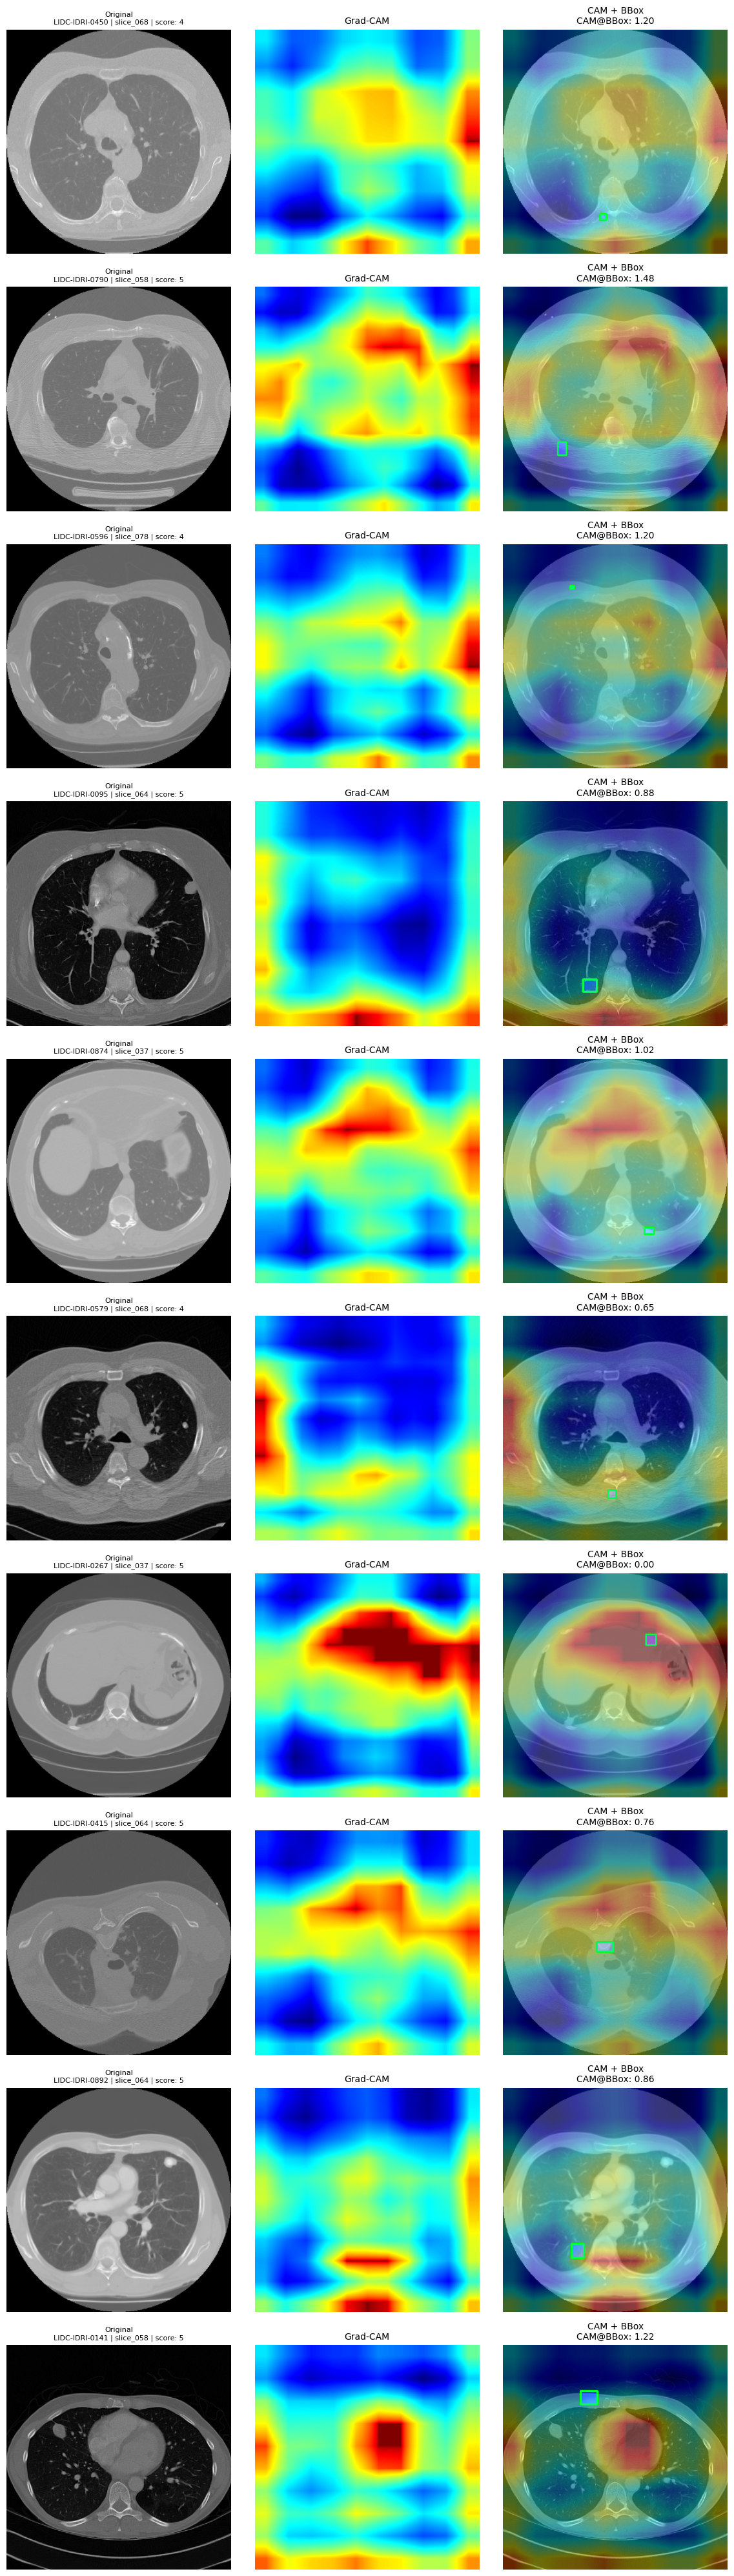

In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import ast

# 내부 모듈
from ResNet18_CBAM_MGA.core.model import ResNet18_CBAM
from ResNet18_CBAM_MGA.core.config import CFG
from ResNet18_CBAM_MGA.visualize.grad_cam import generate_cam

# ✅ 디바이스 설정
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ 경로 설정
data_root = "/data1/lidc-idri/slices"
bbox_csv_path = "/home/iujeong/lung_cancer/csv/bbox_for_npy.csv"
sample_csv_path = "/home/iujeong/lung_cancer/logs/samplewise_metrics.csv"
save_dir = "gradcam_outputs_mask"
os.makedirs(save_dir, exist_ok=True)

# ✅ BBox 로딩
bbox_df = pd.read_csv(bbox_csv_path)
bbox_df['bbox'] = bbox_df['bbox'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
bbox_grouped = bbox_df.groupby('file')['bbox'].apply(list).to_dict()

# ✅ 평가 파일 로딩
df = pd.read_csv(sample_csv_path)

def npy_to_bbox_key(path):
    pid = os.path.basename(os.path.dirname(path))
    fname = os.path.basename(path)  # slice_037_5.npy
    return f"{pid}/{fname}"

df['bbox_key'] = df['file'].apply(npy_to_bbox_key)

# ✅ CAM 결과 불러와서 CAM@BBox >= 0.8인 정답만 필터링
cam_result_df = pd.read_csv("gradcam_outputs_mask/cam_bbox_metrics_best_True.csv")
good_cam_files = set(cam_result_df[cam_result_df['CAM@BBox'] >= 0.8]['file'])

correct_df = df[df['pred'] == df['label']]
correct_df['file_name'] = correct_df['file'].apply(lambda x: os.path.basename(x))
selected = correct_df[correct_df['file_name'].isin(good_cam_files)]
selected = selected.sort_values(by="loss", ascending=True).head(10)

# ✅ 모델 로딩
CFG.model_save_name = "r18_cbam_norotate_sc_no_mask_no_rotate_0522_2045.pth"
model_path = os.path.join("/home/iujeong/lung_cancer/logs", CFG.model_save_name)
model = ResNet18_CBAM(num_classes=CFG.num_classes).to(device).eval()
model.load_state_dict(torch.load(model_path, map_location=device))

# ✅ 결과 저장 리스트 초기화
results = []

# ✅ 시각화 준비
fig, axs = plt.subplots(10, 3, figsize=(12, 40))
fig.subplots_adjust(hspace=0.3)

for row_idx, row in enumerate(selected.itertuples()):
    npy_path = row.file
    bbox_key = row.bbox_key

    # PID, 슬라이스, 스코어 추출
    fname = os.path.basename(npy_path).replace(".npy", "")
    parts = fname.split("_")
    slice_id, score = parts[1], parts[2]
    pid = os.path.basename(os.path.dirname(npy_path))

    # 이미지 로드
    img = np.load(npy_path)
    if img.ndim == 2:
        img = np.expand_dims(img, axis=0)
    img_tensor = torch.tensor(img).unsqueeze(0).float().to(device)

    # Grad-CAM 생성
    cam = generate_cam(model, img_tensor).squeeze().cpu().numpy()
    cam = cv2.resize(cam, (img.shape[2], img.shape[1]))
    cam = np.sqrt(cam)
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    cam_heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

    # 원본 이미지
    ori_img = img[0]
    ori_norm = (ori_img - ori_img.min()) / (ori_img.max() - ori_img.min() + 1e-8)
    ori_bgr = cv2.cvtColor(np.uint8(255 * ori_norm), cv2.COLOR_GRAY2BGR)

    # CAM overlay
    overlay = cv2.addWeighted(ori_bgr, 0.6, cam_heatmap, 0.4, 0)

    # BBox + mask
    mask = np.zeros((img.shape[1], img.shape[2]), dtype=np.uint8)
    for raw_box in bbox_grouped[bbox_key]:
        try:
            box = ast.literal_eval(raw_box) if isinstance(raw_box, str) else raw_box
            if isinstance(box[0][0], list):
                box = box[0]
            (y1, y2), (x1, x2) = box
            cv2.rectangle(overlay, (x1, y1), (x2, y2), (0, 255, 0), 2)
            mask[y1:y2 + 1, x1:x2 + 1] = 1
        except Exception as e:
            print(f"[WARNING] bbox malformed: {raw_box} → {e}")
            continue

    mask_rgb = np.zeros_like(ori_bgr)
    mask_rgb[:, :, 2] = mask * 255
    overlay = cv2.addWeighted(overlay, 1.0, mask_rgb, 0.4, 0)

    # CAM@BBox 계산
    cam_all_mean = cam.mean()
    cam_bbox_mean = cam[mask == 1].mean() if mask.sum() > 0 else 0
    cam_ratio = cam_bbox_mean / (cam_all_mean + 1e-8)

    # 결과 저장
    results.append({
        "file": os.path.basename(npy_path),
        "pid": pid,
        "slice": slice_id,
        "score": score,
        "cam_mean": float(cam_all_mean),
        "cam_bbox_mean": float(cam_bbox_mean),
        "CAM@BBox": float(cam_ratio)
    })

    # 시각화
    axs[row_idx, 0].imshow(ori_bgr)
    axs[row_idx, 0].set_title(f"Original\n{pid} | slice_{slice_id} | score: {score}", fontsize=8)
    axs[row_idx, 1].imshow(cam_heatmap)
    axs[row_idx, 1].set_title("Grad-CAM", fontsize=10)
    axs[row_idx, 2].imshow(overlay)
    axs[row_idx, 2].set_title(f"CAM + BBox\nCAM@BBox: {cam_ratio:.2f}", fontsize=10)
    for col in range(3):
        axs[row_idx, col].axis("off")

    torch.cuda.empty_cache()

# 이미지 저장
out_path = os.path.join(save_dir, "summary_report_bbox_True_top_CAM08.png")
plt.tight_layout()
plt.savefig(out_path)
print(f"📸 CAM 리포트 저장 완료: {out_path}")

# CSV 저장
csv_path = os.path.join(save_dir, "cam_bbox_metrics_best_True_top_CAM08.csv")
pd.DataFrame(results).to_csv(csv_path, index=False)
print(f"📄 CAM@BBox 수치 저장 완료: {csv_path}")

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import ast

# 내부 모듈
from ResNet18_CBAM_MGA.core.model import ResNet18_CBAM
from ResNet18_CBAM_MGA.core.config import CFG
from ResNet18_CBAM_MGA.visualize.grad_cam import generate_cam


device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

# 경로 설정
data_root = "/data1/lidc-idri/slices"
bbox_csv_path = "/home/iujeong/lung_cancer/csv/allbb_noPoly.csv"
sample_csv_path = "/home/iujeong/lung_cancer/logs/samplewise_metrics.csv"
save_dir = "gradcam_outputs_mask"
os.makedirs(save_dir, exist_ok=True)

# ✅ BBox 로딩
bbox_df = pd.read_csv(bbox_csv_path)
bbox_df['bb'] = bbox_df['bb'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) else x[0])
bbox_df['bbox_key'] = bbox_df.apply(lambda row: f"{row['pid']}_{row['slice']}.npy", axis=1)
bbox_grouped = bbox_df.groupby('bbox_key')['bb'].apply(list).to_dict()

# ✅ 평가 파일 로딩
df = pd.read_csv(sample_csv_path)

def npy_to_bbox_key(path):
    pid = os.path.basename(os.path.dirname(path))
    fname = os.path.basename(path)  # slice_037_5.npy
    return f"{pid}_{fname}"  # LIDC-IDRI-0874_slice_037_5.npy

df['bbox_key'] = df['file'].apply(npy_to_bbox_key)
filtered_df = df[df['bbox_key'].isin(bbox_grouped.keys())]

# 정답이 아닌 애들 필터링 (모델이 자신없는 값들)
# selected = filtered_df.sort_values(by="loss", ascending=False).head(10)

# 정답 맞춘 애들만 필터링
correct_df = filtered_df[filtered_df['pred'] == filtered_df['label']]
selected = correct_df.sort_values(by="loss", ascending=True).head(10)

# ✅ 모델 로딩
CFG.model_save_name = "r18_cbam_norotate_sc_no_mask_no_rotate_0522_2045.pth"
model_path = os.path.join("/home/iujeong/lung_cancer/logs", CFG.model_save_name)
model = ResNet18_CBAM(num_classes=CFG.num_classes).to(device).eval()
model.load_state_dict(torch.load(model_path))

# ✅ 결과 저장 리스트 초기화
results = []

# ✅ 시각화 준비
fig, axs = plt.subplots(10, 3, figsize=(12, 40))
fig.subplots_adjust(hspace=0.3)

for row_idx, row in enumerate(selected.itertuples()):
    npy_path = row.file
    bbox_key = row.bbox_key

    # 이미지 로드
    img = np.load(npy_path)
    if img.ndim == 2:
        img = np.expand_dims(img, axis=0)
    img_tensor = torch.tensor(img).unsqueeze(0).float().to(device)

    # Grad-CAM 생성
    cam = generate_cam(model, img_tensor).squeeze().cpu().numpy()
    cam = cv2.resize(cam, (img.shape[2], img.shape[1]))
    cam = np.sqrt(cam)
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    cam_heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

    # 원본 이미지
    ori_img = img[0]
    ori_norm = (ori_img - ori_img.min()) / (ori_img.max() - ori_img.min() + 1e-8)
    ori_bgr = cv2.cvtColor(np.uint8(255 * ori_norm), cv2.COLOR_GRAY2BGR)

    # CAM overlay
    overlay = cv2.addWeighted(ori_bgr, 0.6, cam_heatmap, 0.4, 0)

    # BBox + mask
    mask = np.zeros((img.shape[1], img.shape[2]), dtype=np.uint8)
    for raw_box in bbox_grouped[bbox_key]:
        try:
            box = ast.literal_eval(raw_box) if isinstance(raw_box, str) else raw_box
            if isinstance(box[0][0], list):  # [[[y1, y2], [x1, x2]]]
                box = box[0]
            (y1, y2), (x1, x2) = box
            cv2.rectangle(overlay, (x1, y1), (x2, y2), (0, 255, 0), 2)
            mask[y1:y2 + 1, x1:x2 + 1] = 1
        except Exception as e:
            print(f"[WARNING] bbox malformed: {raw_box} → {e}")
            continue
            torch.cuda.empty_cache()
    

    mask_rgb = np.zeros_like(ori_bgr)
    mask_rgb[:, :, 2] = mask * 255
    overlay = cv2.addWeighted(overlay, 1.0, mask_rgb, 0.4, 0)

    # CAM@BBox 계산
    cam_all_mean = cam.mean()
    cam_bbox_mean = cam[mask == 1].mean() if mask.sum() > 0 else 0
    cam_ratio = cam_bbox_mean / (cam_all_mean + 1e-8)

    # 결과 저장
    results.append({
        "file": os.path.basename(npy_path),
        "cam_mean": float(cam_all_mean),
        "cam_bbox_mean": float(cam_bbox_mean),
        "CAM@BBox": float(cam_ratio)
    })

    # 시각화
    axs[row_idx, 0].imshow(ori_bgr)
    axs[row_idx, 0].set_title(f"Original\n{os.path.basename(npy_path)}", fontsize=8)
    axs[row_idx, 1].imshow(cam_heatmap)
    axs[row_idx, 1].set_title("Grad-CAM", fontsize=10)
    axs[row_idx, 2].imshow(overlay)
    axs[row_idx, 2].set_title(f"CAM + BBox\nCAM@BBox: {cam_ratio:.2f}", fontsize=10)
    for col in range(3):
        axs[row_idx, col].axis("off")

# 이미지 저장
# out_path = os.path.join(save_dir, "summary_report_bbox_False.png")
out_path = os.path.join(save_dir, "summary_report_bbox_True.png")
plt.tight_layout()
plt.savefig(out_path)
print(f"📸 CAM 리포트 저장 완료: {out_path}")

# CSV 저장
# csv_path = os.path.join(save_dir, "cam_bbox_metrics_best_False.csv")
csv_path = os.path.join(save_dir, "cam_bbox_metrics_best_True.csv")
pd.DataFrame(results).to_csv(csv_path, index=False)
print(f"📄 CAM@BBox 수치 저장 완료: {csv_path}")



In [2]:
print("📦 예시 bbox_dict key:", list(bbox_dict.keys())[:5])

📦 예시 bbox_dict key: ['LIDC-IDRI-0538_slice0076.npy', 'LIDC-IDRI-0538_slice0075.npy', 'LIDC-IDRI-0500_slice0051.npy', 'LIDC-IDRI-0500_slice0050.npy', 'LIDC-IDRI-0500_slice0049.npy']


In [ ]:
# ✅ Grad-CAM + BBox + CAM@BBox 자동 리포트 생성기

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import ast

# 내부 모듈
from ResNet18_CBAM_MGA.core.model import ResNet18_CBAM
from ResNet18_CBAM_MGA.core.config import CFG
from ResNet18_CBAM_MGA.visualize.grad_cam import generate_cam

# 경로 설정
data_root = "/data1/lidc-idri/slices"
bbox_csv_path = "/home/iujeong/lung_cancer/csv/allbb_noPoly.csv"
sample_csv_path = "/home/iujeong/lung_cancer/logs/samplewise_metrics.csv"
save_dir = "gradcam_outputs_mask"
os.makedirs(save_dir, exist_ok=True)

# ✅ BBox 로딩
bbox_df = pd.read_csv(bbox_csv_path)
bbox_df['bbox_key'] = bbox_df.apply(lambda row: f"{row['pid']}_{row['slice']}.npy", axis=1)
bbox_grouped = bbox_df.groupby('bbox_key')['bb'].apply(list).to_dict()
bbox_df['bb'] = bbox_df['bb'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) else x[0])

# ✅ 평가 파일 로딩
df = pd.read_csv(sample_csv_path)

def npy_to_bbox_key(path):
    pid = os.path.basename(os.path.dirname(path))
    slice_base = os.path.basename(path).split("_")[:2]  # slice_060_5.npy -> [slice, 060]
    return f"{pid}_{'_'.join(slice_base)}.npy"

df['bbox_key'] = df['file'].apply(npy_to_bbox_key)
filtered_df = df[df['bbox_key'].isin(bbox_grouped.keys())]
selected = filtered_df.sort_values(by="loss", ascending=True).head(10)

# ✅ 모델 로딩
CFG.model_save_name = "r18_cbam_norotate_sc_no_mask_no_rotate_0522_2045.pth"
model_path = os.path.join("/home/iujeong/lung_cancer/logs", CFG.model_save_name)
model = ResNet18_CBAM(num_classes=CFG.num_classes).cuda().eval()
model.load_state_dict(torch.load(model_path))

# ✅ 시각화 준비
fig, axs = plt.subplots(10, 3, figsize=(12, 40))
fig.subplots_adjust(hspace=0.3)

for row_idx, row in enumerate(selected.itertuples()):
    npy_path = row.file
    bbox_key = row.bbox_key

    # 이미지 로드
    img = np.load(npy_path)
    if img.ndim == 2:
        img = np.expand_dims(img, axis=0)
    img_tensor = torch.tensor(img).unsqueeze(0).float().cuda()

    # Grad-CAM 생성
    cam = generate_cam(model, img_tensor).squeeze().cpu().numpy()
    cam = cv2.resize(cam, (img.shape[2], img.shape[1]))
    cam = np.sqrt(cam)
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    cam_heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

    # 원본 이미지
    ori_img = img[0]
    ori_norm = (ori_img - ori_img.min()) / (ori_img.max() - ori_img.min() + 1e-8)
    ori_bgr = cv2.cvtColor(np.uint8(255 * ori_norm), cv2.COLOR_GRAY2BGR)

    # CAM overlay
    overlay = cv2.addWeighted(ori_bgr, 0.6, cam_heatmap, 0.4, 0)

    # BBox + mask
    mask = np.zeros((img.shape[1], img.shape[2]), dtype=np.uint8)
    for raw_box in bbox_grouped[bbox_key]:
        try:
            # 문자열인 경우 → 파싱
            box = ast.literal_eval(raw_box) if isinstance(raw_box, str) else raw_box

            # 박스가 한 겹 더 싸여있는 경우 → 벗기기
            if isinstance(box[0][0], list):  # [[[y1, y2], [x1, x2]]]
                box = box[0]

            (y1, y2), (x1, x2) = box

            # BBox 그리기
            cv2.rectangle(overlay, (x1, y1), (x2, y2), (0, 255, 0), 2)
            mask[y1:y2 + 1, x1:x2 + 1] = 1

        except Exception as e:
            print(f"[WARNING] bbox malformed: {raw_box} → {e}")
            continue

    mask_rgb = np.zeros_like(ori_bgr)
    mask_rgb[:, :, 2] = mask * 255
    overlay = cv2.addWeighted(overlay, 1.0, mask_rgb, 0.4, 0)

    # CAM@BBox 계산
    cam_all_mean = cam.mean()
    cam_bbox_mean = cam[mask==1].mean() if mask.sum() > 0 else 0
    cam_ratio = cam_bbox_mean / (cam_all_mean + 1e-8)

    # 시각화
    axs[row_idx, 0].imshow(ori_bgr)
    axs[row_idx, 0].set_title("Original", fontsize=10)
    axs[row_idx, 0].set_title(f"Original\n{os.path.basename(npy_path)}", fontsize=8)
    axs[row_idx, 1].imshow(cam_heatmap)
    axs[row_idx, 1].set_title("Grad-CAM", fontsize=10)
    axs[row_idx, 2].imshow(overlay)
    axs[row_idx, 2].set_title(f"CAM + BBox\nCAM@BBox: {cam_ratio:.2f}", fontsize=10)
    for col in range(3):
        axs[row_idx, col].axis("off")

# 저장
out_path = os.path.join(save_dir, "summary_report_bbox.png")
plt.tight_layout()
plt.savefig(out_path)
print(f"📸 CAM 리포트 저장 완료: {out_path}")


In [2]:
# BBox 있는 샘플이 얼마나 있는지 확인
print("전체 평가 샘플 수:", len(df))
print("BBox 있는 평가 샘플 수:", len(filtered_df))

# 혹시 0개면?
if len(filtered_df) == 0:
    print("❌ samplewise_metrics.csv 안에 bbox_dict에 해당하는 샘플 없음")

전체 평가 샘플 수: 5332
BBox 있는 평가 샘플 수: 0
❌ samplewise_metrics.csv 안에 bbox_dict에 해당하는 샘플 없음
